In [2]:
#The MNIST dataset from LeCun/Cortes/Burges is already preloaded in the keras module and will be used here
from tensorflow.python import keras
from keras.datasets import mnist 

#It is organized as a tuple of numpy arrays and split in training and test data for both the image data (X) and the labels (y)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#Access information on dataset
help(mnist)

Using TensorFlow backend.


Help on module keras.datasets.mnist in keras.datasets:

NAME
    keras.datasets.mnist - MNIST handwritten digits dataset.

FUNCTIONS
    load_data(path='mnist.npz')
        Loads the MNIST dataset.
        
        # Arguments
            path: path where to cache the dataset locally
                (relative to ~/.keras/datasets).
        
        # Returns
            Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

DATA
    absolute_import = _Feature((2, 5, 0, 'alpha', 1), (3, 0, 0, 'alpha', 0...
    division = _Feature((2, 2, 0, 'alpha', 2), (3, 0, 0, 'alpha', 0), 8192...
    print_function = _Feature((2, 6, 0, 'alpha', 2), (3, 0, 0, 'alpha', 0)...

FILE
    /anaconda3/lib/python3.6/site-packages/keras/datasets/mnist.py




In [3]:
import numpy as np
from skimage import img_as_float
from scipy import stats

#Inspect shape of arrays
print(X_train.shape)#60'000 samples of 28*28 pixel images of digits 0-9
print(y_train.shape)#corresponding labels

print(X_test.shape)#10'000 samples
print(y_test.shape)

#Number of labels (=10, from 0 to 9)
print(len(np.unique(y_train)))

#Flatten 3 dimensional arrays for use in analysis; 784 columns, one for each pixel (28*28)
X_train_data=X_train.reshape((60000,784))
X_test_data=X_test.reshape((10000,784))

#Transform data type to 'float64' which rescales data to range from 0 to 1 using skimage package (see http://scikit-image.org/docs/dev/user_guide/data_types.html)
#Usually a good idea to normalize due to high dimensionality of dataset and wide range of original data type ('uint8':0-255) 
X_train_data=img_as_float(X_train_data) 
X_test_data=img_as_float(X_test_data)

print(X_train_data.shape)
print(X_test_data.shape)

print(X_train_data.dtype)
print(X_test_data.dtype)

#Inspect summary statistics on transformed data set (not done here, because it produces long output)
#stats.describe(X_train_data) 
#Can verify that range of values is indeed from 0 to 1 now

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
10
(60000, 784)
(10000, 784)
float64
float64


In [4]:
import numpy as np
import pandas as pd

#The CNN model used here is implemented within the keras package which is integrated in the tensorflow framework
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Dropout, Activation, ZeroPadding2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

#Initate basic parameters
img_rows, img_cols = 28, 28
num_classes = 10
num_train = len(y_train)
num_test = len(y_test)

#Create one hot encoding of digit classes, necessary for model in keras
y_ohe = keras.utils.to_categorical(y_train, num_classes) 
y_test_ohe = keras.utils.to_categorical(y_test, num_classes)

print(y_train[0], y_ohe[0])
#e.g. the number 5 is now represented by an entry of 1 at index nr. 5 of the one hot encoded vector

5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [5]:
#Image data nedds to be reshaped to include a further dimension for the channel which equals 1 for greyscale images
X = X_train_data.reshape(num_train, img_rows, img_cols, 1)
X_test = X_test_data.reshape(num_test, img_rows, img_cols, 1)

print(X.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
#Model architecture is based on https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/ and https://www.kaggle.com/dansbecker/deep-learning-from-scratch

model = Sequential()

#Build the layer structure;
#The model structure used here is the one also defined in https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/
#I tried out many variations (using strides instead of pooling layers, using more convolutional or dense layers, using more and larger dropouts, larger filters, and tweaking the image transformation parameters) but none of these models improved the accuracy on the test set, so I stayed with this one.
#'32' and '64' represent the number of convolutions or filters that are applied and kernel_size is the size of those filters in pixels
#The activation function used is ReLU (rectified linear unit, f(x) = max(0, x)) which is one of the most common nowadays.

model.add(Conv2D(32, (3, 3), input_shape=(img_rows, img_cols, 1)))
BatchNormalization(axis=-1)
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
BatchNormalization(axis=-1)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3, 3)))
BatchNormalization(axis=-1)
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
BatchNormalization(axis=-1)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())#Flatten input layer to one dimension to prepare for classification 

#Dense layers aka fully connected layers. These layers give the ability to classify the features learned by the CNN.
model.add(Dense(512))
BatchNormalization()
model.add(Activation('relu'))
model.add(Dropout(0.2))#Dropouts prevent overfitting by randomly disactivating the specified portion of neurons in the preceding layer

#The output layers. Uses softmax activation (multinomial logistic regression) to calculate a probability for every class.
#The class with the maximum probability is the model’s prediction for the input.
model.add(Dense(10))
model.add(Activation('softmax'))


#Compile model by determining loss function (categorical cross-entropy loss) and optimization algorithm ('Adam')
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

#Apply various transformations to the input images to prevent overfitting (data augmentation)
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)
test_gen = ImageDataGenerator()

#Set training and test generators and supply a batch size to use less memory and train faster
train_generator = gen.flow(X, y_ohe, batch_size=64)
test_generator = test_gen.flow(X_test, y_test_ohe, batch_size=64)

#Fit the model, run over the dataset 5 times (epochs) in batches of 64 images
model.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=5, 
                    validation_data=test_generator, validation_steps=10000//64)

Epoch 1/5
937/937 [==============================] - 143s 153ms/step - loss: 0.2071 - acc: 0.9356 - val_loss: 0.0267 - val_acc: 0.9917
Epoch 2/5
937/937 [==============================] - 129s 138ms/step - loss: 0.0644 - acc: 0.9808 - val_loss: 0.0232 - val_acc: 0.9918
Epoch 3/5
937/937 [==============================] - 115s 122ms/step - loss: 0.0467 - acc: 0.9858 - val_loss: 0.0213 - val_acc: 0.9927
Epoch 4/5
937/937 [==============================] - 122s 131ms/step - loss: 0.0377 - acc: 0.9879 - val_loss: 0.0225 - val_acc: 0.9935
Epoch 5/5
937/937 [==============================] - 125s 134ms/step - loss: 0.0338 - acc: 0.9893 - val_loss: 0.0157 - val_acc: 0.9951


In [7]:
#Inspect the layer outputs
model.summary()
#We can see how the 2x2 pooling cuts the feature map to one forth of the size (as it is supposed to, to prevent overfitting (=down-sampling))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 10, 10, 64)        0         
__________

In [8]:
#Reproduce the accuracy score on the test data
score = model.evaluate(X_test, y_test_ohe)
print()
print('Test accuracy: ', score[1])

#This accuracy score (0.9951) beats the one obtained for the SVM model (0.973)

10000/10000 [==============================] - 6s 630us/step

Test accuracy:  0.9951


In [9]:
#Predict digits from the test set
predictions = model.predict_classes(X_test)

print(predictions[:20])
print(y_test[:20])

#All predictions are now correct in this small sample

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [10]:
#Metrics, same as for SVM for comparison

#Import `metrics`
from sklearn import metrics

#Print the classification report of `y_test` and `predicted`
print(metrics.classification_report(y_test, predictions))

#Print the confusion matrix
print(metrics.confusion_matrix(y_test, predictions))

#We can see how the CNN was able to improve the accuracy further compared to the SVM model

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      0.99      1.00      1135
           2       1.00      0.99      0.99      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       1.00      1.00      1.00       892
           6       1.00      0.99      1.00       958
           7       0.99      1.00      0.99      1028
           8       1.00      1.00      1.00       974
           9       0.99      0.99      0.99      1009

   micro avg       1.00      1.00      1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

[[ 978    0    0    0    0    0    0    1    1    0]
 [   0 1129    0    0    0    0    0    6    0    0]
 [   1    0 1025    0    1    0    0    5    0    0]
 [   0    0    2 1006    0    1    0    0    1    0]
 [   0    0    0    0  978   

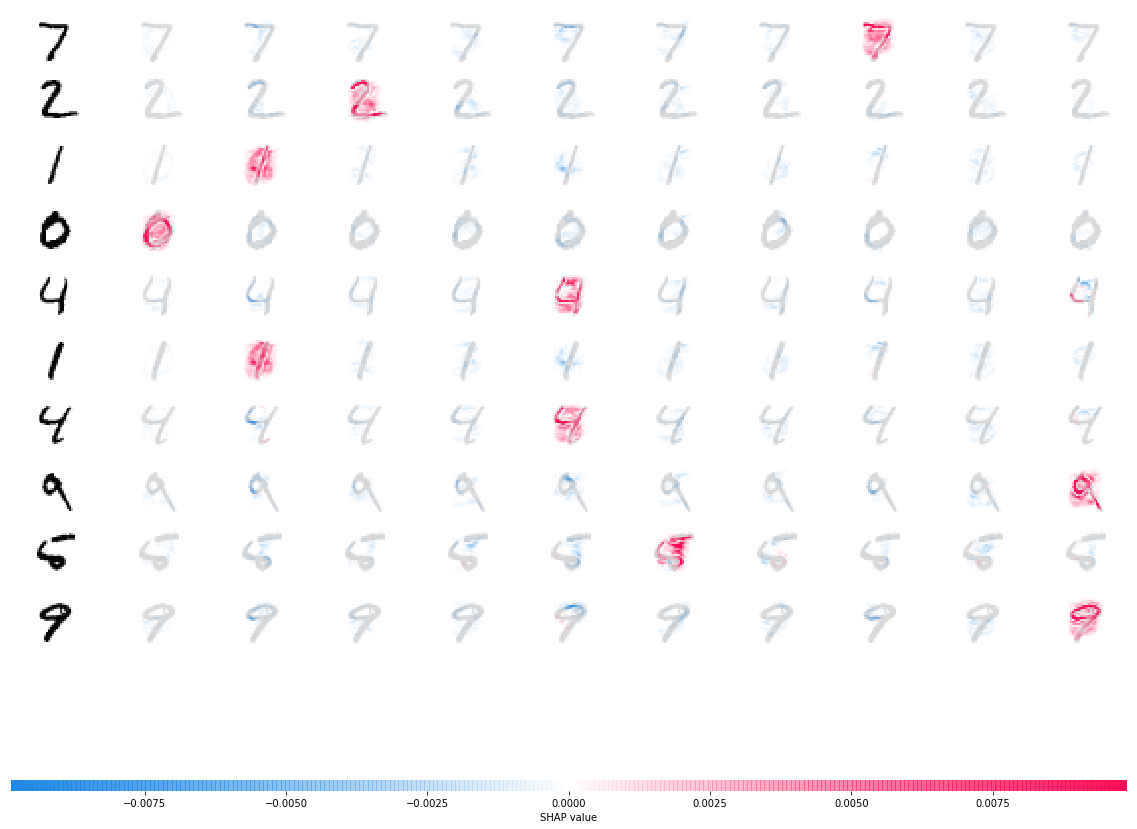

In [12]:
#Finally, as the cherry on the pie (or rather a gimmick), I wanted to implement SHAP values. 
#These values allow quantifying the effect each input feature has on a certain prediction. 
#I became aware of this new concept through Dan Becker from Kaggle Learn (https://www.kaggle.com/dansbecker/shap-values).
#These values can be interpreted similarly to the coefficient estimates in a regression which indicate ceteris paribus effects.
#For image classification, we ask which pixels have an important impact on the class prediction.
#Details on the approach can be found in the original paper: http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions
#I copied this chunk of code from the official shap repo, see 'Deep learning example with DeepExplainer' on this page: https://github.com/slundberg/shap

import shap

#Select a set of background examples to take an expectation over
background = X[np.random.choice(X.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(X_test[:10])

# plot the feature attributions
shap.image_plot(shap_values, -X_test[:10])

#On the left side we have a selection of digit images from the test set (the first ten entries).
#Then we 'test' this digit image over all possible classes from 0 to 9. Red dots mean that these pixels increase the probability of the corresponding class. Blue means a decrease in predicted probability for that class.
#For example, we can see how the model manages to recognize a badly written '5' and not mistake it for a '6'.
#It 'sees' that the upper part is rather edgy and the lack of connection at the lower left part which is accounted for by the blue spots when evaluating class '6.'